# YanuX Skeletron User Study

## Imports

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime, date, time

## Helper Functions

In [2]:
def print_stats(data, hist_bins=None, plt_size=(8,4)):
    print('--- Statistics ----')
    display(data.describe())
    print('\n')
    print('--- Counting Unique Values ----')
    value_counts = data.value_counts()
    display(value_counts)
    print('\n')
    if hist_bins is None:
        print('--- Basic Bar Chart ----')
        value_counts.sort_index().plot(kind='bar', figsize=plt_size)
    else:
        print('--- Basic Histogram ----')
        data.hist(bins=hist_bins, figsize=plt_size)
    plt.show()
    
def calculate_sus(data):
    for i in range(len(data.columns)):
        if i % 2:
            data.iloc[:,i] = 7 - data.iloc[:,i]
        else:
            data.iloc[:,i] = data.iloc[:,i] - 1

    data['Score'] = data.iloc[:,0:10].sum(axis=1)
    data['Score 100'] = data['Score'] * (100/60)
    return data

def confidence_interval_t(data, confidence_level=0.95):
    return stats.t.interval(confidence_level, data.count()-1, data.mean(), data.sem())

def convert_time_to_timedelta(value):
    return datetime.combine(date.min, value) - datetime.min

## Load Excel

In [3]:
data = pd.read_excel('data/userstudies/yanux-skeletron-data.xlsx', sheet_name=None)  

## Demographics

In [4]:
data_demographics = data['Demographics']
data_demographics

,Age,Gender,Education,Education Area,Devices Owned,Usage of Multiple Devices
0,52,Male,Master's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone",7
1,23,Female,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone",5
2,24,Female,Bachelor's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",6
3,22,Male,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Smart TV",3
4,22,Male,Post-Secondary Education,Computer Science,"Desktop computer, Laptop computer, Smartphone",6
5,24,Female,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Tablet, Smartwatc...",5
6,35,Male,Master's Degree,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",7
7,25,Male,Bachelor's Degree,Computer Science,"Laptop computer, Smartphone, Tablet, Smart TV,...",5
8,29,Female,Secondary Education,Computer Science,"Desktop computer, Laptop computer, Smartphone,...",7


### Age

--- Statistics ----


count     9.000000
mean     28.444444
std       9.761034
min      22.000000
25%      23.000000
50%      24.000000
75%      29.000000
max      52.000000
Name: Age, dtype: float64



--- Counting Unique Values ----


24    2
22    2
52    1
23    1
35    1
25    1
29    1
Name: Age, dtype: int64



--- Basic Histogram ----


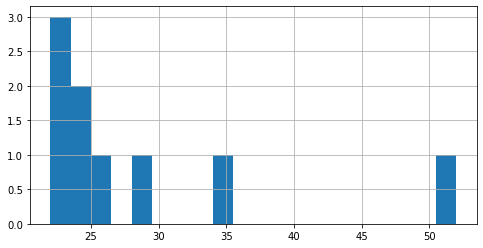

Population Standard Deviation:
9.202790773710515


In [5]:
data_demographics_age = data_demographics['Age']
print_stats(data_demographics_age, hist_bins=20)
print('Population Standard Deviation:')
print(data_demographics_age.std(ddof=0))

### Gender

--- Statistics ----


count        9
unique       2
top       Male
freq         5
Name: Gender, dtype: object



--- Counting Unique Values ----


Male      5
Female    4
Name: Gender, dtype: int64



--- Basic Bar Chart ----


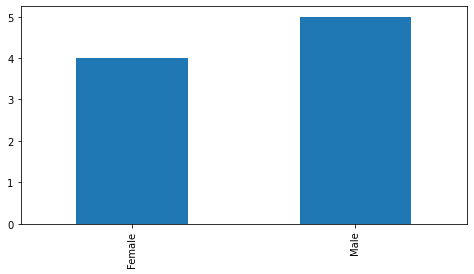

In [6]:
data_demographics_genre = data_demographics['Gender']
print_stats(data_demographics_genre)

### Education

--- Statistics ----


count                     9
unique                    4
top       Bachelor's Degree
freq                      5
Name: Education, dtype: object



--- Counting Unique Values ----


Bachelor's Degree           5
Master's Degree             2
Post-Secondary Education    1
Secondary Education         1
Name: Education, dtype: int64



--- Basic Bar Chart ----


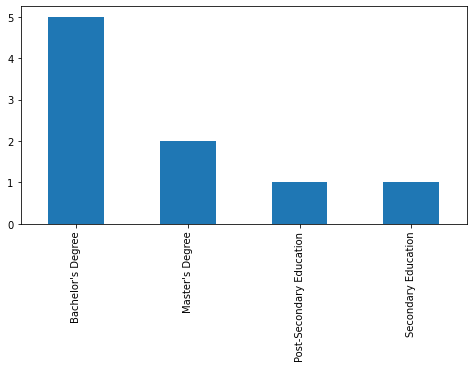

In [7]:
data_demographics_education = data_demographics['Education']
print_stats(data_demographics_education)

### Education Area

--- Statistics ----


count                    9
unique                   1
top       Computer Science
freq                     9
Name: Education Area, dtype: object



--- Counting Unique Values ----


Computer Science    9
Name: Education Area, dtype: int64



--- Basic Bar Chart ----


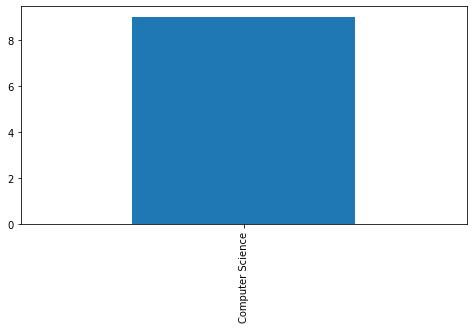

In [8]:
data_demographics_education_area = data_demographics['Education Area']
print_stats(data_demographics_education_area)

### Devices Owned

In [9]:
data_demographics_devices_owned = data_demographics['Devices Owned']
data_demographics_devices_owned_list = data_demographics_devices_owned.map(lambda x: [i.strip() for i in x.split(",")])

print('--- Statistics ----')
display(data_demographics_devices_owned_list.describe())
print('--- Counting Unique Values ----')
display(data_demographics_devices_owned.value_counts())

--- Statistics ----


count                                                   9
unique                                                  8
top       [Desktop computer, Laptop computer, Smartphone]
freq                                                    2
Name: Devices Owned, dtype: object

--- Counting Unique Values ----


Desktop computer, Laptop computer, Smartphone                                                   2
Laptop computer, Smartphone                                                                     1
Desktop computer, Laptop computer, Smartphone, Tablet, Smart TV, Smartwatch                     1
Laptop computer, Smartphone, Smart TV                                                           1
Laptop computer, Smartphone, Tablet, Smartwatch, Smart speaker                                  1
Desktop computer, Laptop computer, Smartphone, Tablet, Smart TV, Smartwatch, Fitness tracker    1
Laptop computer, Smartphone, Tablet, Smart TV, Fitness tracker                                  1
Desktop computer, Laptop computer, Smartphone, Tablet, Fitness tracker                          1
Name: Devices Owned, dtype: int64

#### Number of Devices Owned

In [10]:
mlb_devices_owned = MultiLabelBinarizer()
devices_owned_one_hot = pd.DataFrame(mlb_devices_owned.fit_transform(data_demographics_devices_owned_list),
                                     columns=mlb_devices_owned.classes_,index=data_demographics_devices_owned_list.index)
devices_owned_one_hot

,Desktop computer,Fitness tracker,Laptop computer,Smart TV,Smart speaker,Smartphone,Smartwatch,Tablet
0,1,0,1,0,0,1,0,0
1,0,0,1,0,0,1,0,0
2,1,0,1,1,0,1,1,1
3,0,0,1,1,0,1,0,0
4,1,0,1,0,0,1,0,0
5,0,0,1,0,1,1,1,1
6,1,1,1,1,0,1,1,1
7,0,1,1,1,0,1,0,1
8,1,1,1,0,0,1,0,1


In [11]:
devices_owned_one_hot.sum(axis=1).describe()

count    9.000000
mean     4.333333
std      1.658312
min      2.000000
25%      3.000000
50%      5.000000
75%      5.000000
max      7.000000
dtype: float64

##### Device Types Owned

In [12]:
devices_owned_one_hot.sum().sort_values(ascending=False)

Laptop computer     9
Smartphone          9
Desktop computer    5
Tablet              5
Smart TV            4
Fitness tracker     3
Smartwatch          3
Smart speaker       1
dtype: int64

##### Percentage of Participants that Own Each Type of Device

In [13]:
(devices_owned_one_hot.sum()/devices_owned_one_hot.count()*100).sort_values(ascending=False)

Laptop computer     100.000000
Smartphone          100.000000
Desktop computer     55.555556
Tablet               55.555556
Smart TV             44.444444
Fitness tracker      33.333333
Smartwatch           33.333333
Smart speaker        11.111111
dtype: float64

### Usage of Multiple Devices

--- Statistics ----


count    9.000000
mean     5.666667
std      1.322876
min      3.000000
25%      5.000000
50%      6.000000
75%      7.000000
max      7.000000
Name: Usage of Multiple Devices, dtype: float64



--- Counting Unique Values ----


7    3
5    3
6    2
3    1
Name: Usage of Multiple Devices, dtype: int64



--- Basic Bar Chart ----


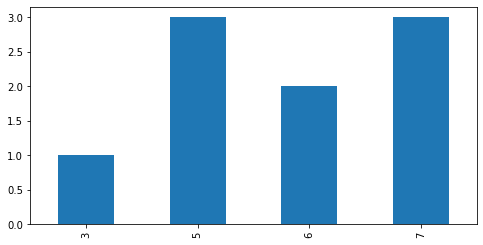

Population Standard Deviation:
1.247219128924647


In [14]:
data_demographics_usage_multiple_devices = data_demographics['Usage of Multiple Devices']
print_stats(data_demographics_usage_multiple_devices)

print('Population Standard Deviation:')
print(data_demographics_usage_multiple_devices.std(ddof=0))

#### Percentage of Users that User Multiple Devices Sometimes or More Often

In [15]:
(data_demographics_usage_multiple_devices[data_demographics_usage_multiple_devices >= 5].count()/data_demographics_usage_multiple_devices.count())*100

88.88888888888889

## Programming Experience

In [16]:
data_programming_experience = data['Programming Experience']
data_programming_experience

,Years of Programming Experience,Programming Experience (Self Assessment),JavaScript Experience (Self Assessment),Experience with Programming Languages
0,30,6,6,"C, C++, C#, Delphi/Pascal, Java, Perl, PHP, Py..."
1,5,6,6,"C#, Dart, Java, Kotlin, Matlab, PHP, TypeScript"
2,6,4,4,"C++, C#, Java, Kotlin"
3,5,6,5,"C, C++, Java, Python, Ruby"
4,7,5,5,"C, C#, Dart, Java, Matlab, PHP, Python, R, Vis..."
5,5,4,4,"C, C#, Java, Python"
6,20,7,7,"C, C#, Java, PHP, Python, Visual Basic/Visual ..."
7,6,5,5,"C, C#, Dart, Java, Python, TypeScript"
8,4,3,3,"C, C++, C#, Java, Python, Visual Basic/Visual ..."


### Years of Programming Experience

--- Statistics ----


count     9.000000
mean      9.777778
std       9.024658
min       4.000000
25%       5.000000
50%       6.000000
75%       7.000000
max      30.000000
Name: Years of Programming Experience, dtype: float64



--- Counting Unique Values ----


5     3
6     2
30    1
7     1
20    1
4     1
Name: Years of Programming Experience, dtype: int64



--- Basic Histogram ----


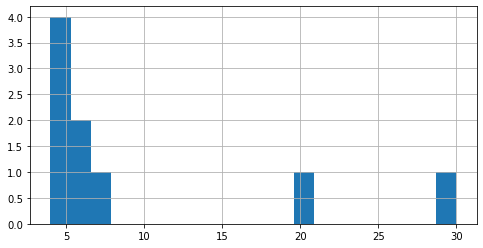

Population Standard Deviation:
8.508528764034066


In [17]:
data_programming_experience_years = data_programming_experience['Years of Programming Experience']
print_stats(data_programming_experience_years, hist_bins=20)
print('Population Standard Deviation:')
print(data_programming_experience_years.std(ddof=0))

### Programming Experience (Self Assessment)

--- Statistics ----


count    9.000000
mean     5.111111
std      1.269296
min      3.000000
25%      4.000000
50%      5.000000
75%      6.000000
max      7.000000
Name: Programming Experience (Self Assessment), dtype: float64



--- Counting Unique Values ----


6    3
4    2
5    2
7    1
3    1
Name: Programming Experience (Self Assessment), dtype: int64



--- Basic Bar Chart ----


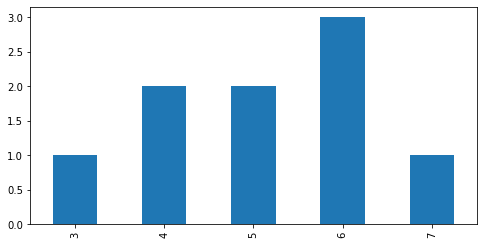

Population Standard Deviation:
1.1967032904743342


In [18]:
data_programming_experience_self = data_programming_experience['Programming Experience (Self Assessment)']
print_stats(data_programming_experience_self)
print('Population Standard Deviation:')
print(data_programming_experience_self.std(ddof=0))

### JavaScript Experience (Self Assessment)

--- Statistics ----


count    9.000000
mean     5.000000
std      1.224745
min      3.000000
25%      4.000000
50%      5.000000
75%      6.000000
max      7.000000
Name: JavaScript Experience (Self Assessment), dtype: float64



--- Counting Unique Values ----


5    3
6    2
4    2
7    1
3    1
Name: JavaScript Experience (Self Assessment), dtype: int64



--- Basic Bar Chart ----


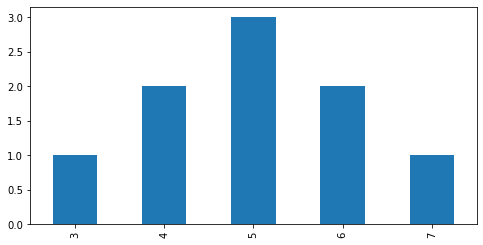

Population Standard Deviation:
1.1547005383792515


In [19]:
data_programming_experience_javascript = data_programming_experience['JavaScript Experience (Self Assessment)']
print_stats(data_programming_experience_javascript)
print('Population Standard Deviation:')
print(data_programming_experience_javascript.std(ddof=0))

### Experience with Programming Languages

In [20]:
data_programming_experience_languages = data_programming_experience['Experience with Programming Languages']
data_programming_experience_languages_list = data_programming_experience_languages.map(lambda x: [i.strip() for i in x.split(",")])

print('--- Statistics ----')
display(data_programming_experience_languages_list.describe())
print('--- Counting Unique Values ----')
display(data_programming_experience_languages.value_counts())

--- Statistics ----


count                                                     9
unique                                                    9
top       [C, C++, C#, Delphi/Pascal, Java, Perl, PHP, P...
freq                                                      1
Name: Experience with Programming Languages, dtype: object

--- Counting Unique Values ----


C, C++, C#, Delphi/Pascal, Java, Perl, PHP, Python, Visual Basic/Visual Basic for Applications    1
C#, Dart, Java, Kotlin, Matlab, PHP, TypeScript                                                   1
C++, C#, Java, Kotlin                                                                             1
C, C++, Java, Python, Ruby                                                                        1
C, C#, Dart, Java, Matlab, PHP, Python, R, Visual Basic/Visual Basic for Applications             1
C, C#, Java, Python                                                                               1
C, C#, Java, PHP, Python, Visual Basic/Visual Basic for Applications                              1
C, C#, Dart, Java, Python, TypeScript                                                             1
C, C++, C#, Java, Python, Visual Basic/Visual Basic for Applications                              1
Name: Experience with Programming Languages, dtype: int64

#### Programming Languages

In [21]:
mlb_programming_languages = MultiLabelBinarizer()
programming_languages_one_hot = pd.DataFrame(mlb_programming_languages.fit_transform(data_programming_experience_languages_list),
                                             columns=mlb_programming_languages.classes_,index=data_programming_experience_languages_list.index)
programming_languages_one_hot

,C,C#,C++,Dart,Delphi/Pascal,Java,Kotlin,Matlab,PHP,Perl,Python,R,Ruby,TypeScript,Visual Basic/Visual Basic for Applications
0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,1
1,0,1,0,1,0,1,1,1,1,0,0,0,0,1,0
2,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0
4,1,1,0,1,0,1,0,1,1,0,1,1,0,0,1
5,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
6,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1
7,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0
8,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1


In [22]:
programming_languages_one_hot.sum(axis=1).describe()

count    9.000000
mean     6.222222
std      1.855921
min      4.000000
25%      5.000000
50%      6.000000
75%      7.000000
max      9.000000
dtype: float64

##### Number of Programming Languages per Participant

In [23]:
programming_languages_one_hot.sum().sort_values(ascending=False)

Java                                          9
C#                                            8
C                                             7
Python                                        7
C++                                           4
PHP                                           4
Visual Basic/Visual Basic for Applications    4
Dart                                          3
Kotlin                                        2
Matlab                                        2
TypeScript                                    2
Delphi/Pascal                                 1
Perl                                          1
R                                             1
Ruby                                          1
dtype: int64

##### Percentage of Participants that Own Each Type of Device

In [24]:
(programming_languages_one_hot.sum()/programming_languages_one_hot.count()*100).sort_values(ascending=False)

Java                                          100.000000
C#                                             88.888889
C                                              77.777778
Python                                         77.777778
C++                                            44.444444
PHP                                            44.444444
Visual Basic/Visual Basic for Applications     44.444444
Dart                                           33.333333
Kotlin                                         22.222222
Matlab                                         22.222222
TypeScript                                     22.222222
Delphi/Pascal                                  11.111111
Perl                                           11.111111
R                                              11.111111
Ruby                                           11.111111
dtype: float64

## Domain Specific Questions

- **DS1:** It makes sense that the UI state of an application is represented by an object.
- **DS2:** I understood how to save the UI state of an application every time it changes.
- **DS3:** I understood how to use the "Coordinator" API to perform various tasks that make my multi-device application behave properly?
- **DS4:** I understood how the DSL (Domain Specific Language) for the automatic distribution of UI components works.
- **DS5:** I understood how to use the "ComponentsRuleEngine" to determine the appropriate distribution of UI components based on the restrictions placed on them and the proxemics relationships between devices currently running application instances.
- **DS6:** I understood how the custom "YanuX Resource Management Element" can be used to manage multiple application states of an application.
- **DS7:** I understood how the custom "YanuX Components Distribution Element" can be used to manage the distribution of UI components of an application.	
- **DS8:** It makes sense to distribute the UI components of an application depending on how closely related the surrounding devices are.

In [25]:
data_domain_specific = data['Domain Specific']
data_domain_specific

,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
0,7,7,7,7,7,7,7,7
1,7,6,6,6,5,6,6,5
2,5,7,6,6,6,6,6,7
3,7,6,6,6,6,6,6,7
4,6,6,6,6,6,6,6,6
5,7,6,6,5,5,6,5,6
6,7,6,7,7,7,7,6,7
7,7,7,7,7,6,6,7,6
8,7,6,6,5,7,7,6,7


--- Statistics ----


,DS1,DS2,DS3,DS4,DS5,DS6,DS7,DS8
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,6.666667,6.333333,6.333333,6.111111,6.111111,6.333333,6.111111,6.444444
std,0.707107,0.500000,0.500000,0.781736,0.781736,0.500000,0.600925,0.726483
min,5.000000,6.000000,6.000000,5.000000,5.000000,6.000000,5.000000,5.000000
25%,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
50%,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000




--- Counting Unique Values ----


DS1  DS2  DS3  DS4  DS5  DS6  DS7  DS8
5    7    6    6    6    6    6    7      1
6    6    6    6    6    6    6    6      1
7    6    6    5    5    6    5    6      1
                    7    7    6    7      1
               6    5    6    6    5      1
                    6    6    6    7      1
          7    7    7    7    6    7      1
     7    7    7    6    6    7    6      1
                    7    7    7    7      1
dtype: int64



--- Basic Histogram ----


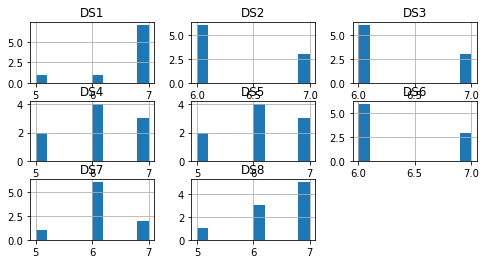

In [26]:
print_stats(data_domain_specific, hist_bins=10)

### Response Frequency

In [27]:
data_domain_specific_freq = (data_domain_specific.apply(pd.value_counts).fillna(0)/data_domain_specific.count()*100).transpose()
data_domain_specific_freq

,5,6,7
DS1,11.111111,11.111111,77.777778
DS2,0.000000,66.666667,33.333333
DS3,0.000000,66.666667,33.333333
DS4,22.222222,44.444444,33.333333
DS5,22.222222,44.444444,33.333333
DS6,0.000000,66.666667,33.333333
DS7,11.111111,66.666667,22.222222
DS8,11.111111,33.333333,55.555556


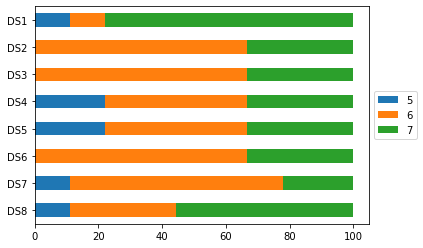

In [28]:
data_domain_specific_freq.iloc[::-1].plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

## UMUX-Lite
- **ULI1:** The YanuX Framework's capabilities meet my requirements.
- **ULI2:** The YanuX Framework is easy to use.

In [29]:
data_umux_lite = data['UMUX-Lite']
data_umux_lite

,ULI1,ULI2
0,7,7
1,4,6
2,6,6
3,7,7
4,7,6
5,6,7
6,6,7
7,6,7
8,7,5


--- Statistics ----


,ULI1,ULI2
count,9.000000,9.000000
mean,6.222222,6.444444
std,0.971825,0.726483
min,4.000000,5.000000
25%,6.000000,6.000000
50%,6.000000,7.000000
75%,7.000000,7.000000
max,7.000000,7.000000




--- Counting Unique Values ----


ULI1  ULI2
6     7       3
7     7       2
4     6       1
6     6       1
7     5       1
      6       1
dtype: int64



--- Basic Histogram ----


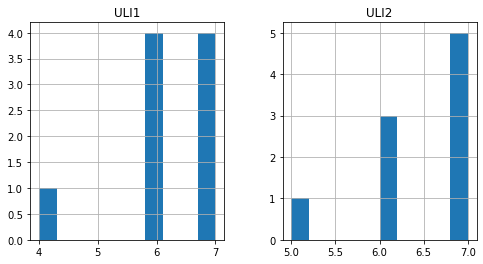

In [30]:
print_stats(data_umux_lite, hist_bins=10)

### Response Frequency

In [31]:
data_umux_lite_freq = (data_umux_lite.apply(pd.value_counts).fillna(0)/data_umux_lite.count()*100).transpose()
data_umux_lite_freq

,4,5,6,7
ULI1,11.111111,0.000000,44.444444,44.444444
ULI2,0.000000,11.111111,33.333333,55.555556


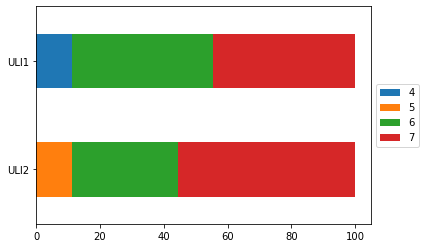

In [32]:
data_umux_lite_freq.iloc[::-1].plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### SUS Conversion

In [33]:
data_umux_lite['SUS'] = 0.65 * ((data_umux_lite['ULI1'] + data_umux_lite['ULI2'] - 2) * (100/12))+22.9
data_umux_lite

,ULI1,ULI2,SUS
0,7,7,87.900000
1,4,6,66.233333
2,6,6,77.066667
3,7,7,87.900000
4,7,6,82.483333
5,6,7,82.483333
6,6,7,82.483333
7,6,7,82.483333
8,7,5,77.066667


In [34]:
data_umux_lite['SUS'].describe()

count     9.000000
mean     80.677778
std       6.634035
min      66.233333
25%      77.066667
50%      82.483333
75%      82.483333
max      87.900000
Name: SUS, dtype: float64

## Semantic Differential Scales
- **SDS1:** Uninteresting/Interesting
- **SDS2:** Complex/Simple
- **SDS3:** Inappropriate/Appropriate
- **SDS4:** Hard to Understand/Easy to Understand
- **SDS5:** Hard to Learn/Easy to Learn
- **SDS6:** Hard to Develop/Easy to Develop

In [35]:
data_sds = data['Semantic Differential Scales']
data_sds

,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
0,7,5,7,7,7,7
1,5,6,6,7,7,7
2,7,2,6,3,6,2
3,7,6,7,6,7,7
4,7,6,7,6,6,6
5,7,7,7,7,7,5
6,7,7,7,7,7,7
7,7,6,6,6,6,6
8,7,5,6,5,5,5


--- Statistics ----


,SDS1,SDS2,SDS3,SDS4,SDS5,SDS6
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,6.777778,5.555556,6.555556,6.000000,6.444444,5.777778
std,0.666667,1.509231,0.527046,1.322876,0.726483,1.641476
min,5.000000,2.000000,6.000000,3.000000,5.000000,2.000000
25%,7.000000,5.000000,6.000000,6.000000,6.000000,5.000000
50%,7.000000,6.000000,7.000000,6.000000,7.000000,6.000000
75%,7.000000,6.000000,7.000000,7.000000,7.000000,7.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000




--- Counting Unique Values ----


SDS1  SDS2  SDS3  SDS4  SDS5  SDS6
5     6     6     7     7     7       1
7     2     6     3     6     2       1
      5     6     5     5     5       1
            7     7     7     7       1
      6     6     6     6     6       1
            7     6     6     6       1
                        7     7       1
      7     7     7     7     5       1
                              7       1
dtype: int64



--- Basic Histogram ----


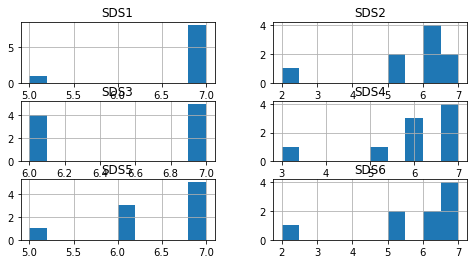

In [36]:
print_stats(data_sds, hist_bins=10)

### Response Frequency

In [37]:
data_sds_freq = (data_sds.apply(pd.value_counts).fillna(0)/data_sds.count()*100).transpose()
data_sds_freq

,2,3,5,6,7
SDS1,0.000000,0.000000,11.111111,0.000000,88.888889
SDS2,11.111111,0.000000,22.222222,44.444444,22.222222
SDS3,0.000000,0.000000,0.000000,44.444444,55.555556
SDS4,0.000000,11.111111,11.111111,33.333333,44.444444
SDS5,0.000000,0.000000,11.111111,33.333333,55.555556
SDS6,11.111111,0.000000,22.222222,22.222222,44.444444


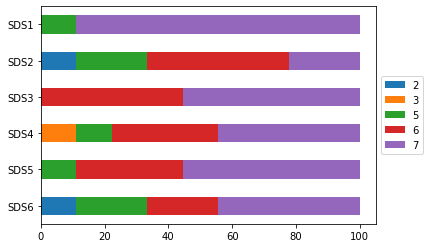

In [38]:
data_sds_freq.iloc[::-1].plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### Overall Pseudo-Semantic Differential Scale Score

In [39]:
data_sds_score = data_sds.mean(axis=1)
data_sds_score

0    6.666667
1    6.333333
2    4.333333
3    6.666667
4    6.333333
5    6.666667
6    7.000000
7    6.166667
8    5.500000
dtype: float64

In [40]:
data_sds_score.describe()

count    9.000000
mean     6.185185
std      0.814131
min      4.333333
25%      6.166667
50%      6.333333
75%      6.666667
max      7.000000
dtype: float64

## NPS

In [41]:
data_nps = data['NPS']
data_nps

,NPS
0,9
1,8
2,9
3,9
4,8
5,7
6,10
7,10
8,10


### Calculate NPS

In [42]:
nps_count = data_nps['NPS'].count()
nps_promoters = data_nps['NPS'][data_nps['NPS'] >= 9].count()
nps_detractors = data_nps['NPS'][data_nps['NPS'] <= 6].count()

nps_promoters_per = nps_promoters/nps_count*100
nps_detractors_per = nps_detractors/nps_count*100

nps_score = nps_promoters_per - nps_detractors_per
print('NPS Count', nps_count)
print('NPS Promoters', nps_promoters)
print('NPS Detractors', nps_detractors)
print('NPS Promoters (Percentage)', nps_promoters_per)
print('NPS Detractors (Percentage)', nps_detractors_per)

NPS Count 9
NPS Promoters 6
NPS Detractors 0
NPS Promoters (Percentage) 66.66666666666666
NPS Detractors (Percentage) 0.0


### General Stats

--- Statistics ----


,NPS
count,9.000000
mean,8.888889
std,1.054093
min,7.000000
25%,8.000000
50%,9.000000
75%,10.000000
max,10.000000




--- Counting Unique Values ----


NPS
9      3
10     3
8      2
7      1
dtype: int64



--- Basic Bar Chart ----


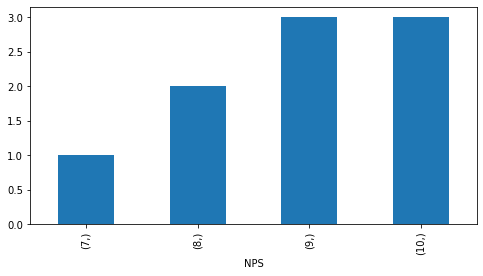

In [43]:
print_stats(data_nps)

## NASA TLX

In [44]:
data_nasa_tlx = data['NASA TLX']
data_nasa_tlx['Score'] = data_nasa_tlx.mean(axis=1)
data_nasa_tlx

,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,Score
0,60,20,35,10,30,15,28.333333
1,45,0,45,15,25,5,22.500000
2,75,35,50,30,70,35,49.166667
3,65,0,85,10,40,15,35.833333
4,15,5,5,10,90,0,20.833333
5,45,0,75,60,85,10,45.833333
6,10,0,10,15,35,5,12.500000
7,10,0,0,5,5,0,3.333333
8,30,0,5,25,10,10,13.333333


--- Statistics ----


,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,Score
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,39.444444,6.666667,34.444444,20.000000,43.333333,10.555556,25.740741
std,24.551533,12.500000,31.765198,16.955825,31.224990,10.736749,15.520173
min,10.000000,0.000000,0.000000,5.000000,5.000000,0.000000,3.333333
25%,15.000000,0.000000,5.000000,10.000000,25.000000,5.000000,13.333333
50%,45.000000,0.000000,35.000000,15.000000,35.000000,10.000000,22.500000
75%,60.000000,5.000000,50.000000,25.000000,70.000000,15.000000,35.833333
max,75.000000,35.000000,85.000000,60.000000,90.000000,35.000000,49.166667




--- Counting Unique Values ----


Mental Demand  Physical Demand  Temporal Demand  Performance  Effort  Frustration  Score    
10             0                0                5            5       0            3.333333     1
                                10               15           35      5            12.500000    1
15             5                5                10           90      0            20.833333    1
30             0                5                25           10      10           13.333333    1
45             0                45               15           25      5            22.500000    1
                                75               60           85      10           45.833333    1
60             20               35               10           30      15           28.333333    1
65             0                85               10           40      15           35.833333    1
75             35               50               30           70      35           49.166667    1
dtype: int64



--- Basic Histogram ----


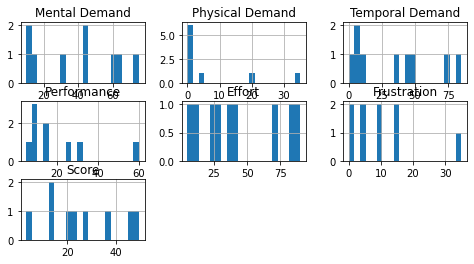

In [45]:
print_stats(data_nasa_tlx, hist_bins=20)

## SEQ Exercises

In [46]:
data_seq = data['SEQ']
data_seq

,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
0,6,6,7,7,7,7,6,7,6,7,7
1,6,6,7,7,7,7,7,7,7,7,7
2,6,5,7,7,7,7,7,7,6,7,7
3,6,5,6,7,6,7,5,7,4,6,7
4,6,5,7,7,7,7,6,7,5,7,7
5,3,2,3,7,6,7,4,7,1,7,6
6,7,6,7,7,7,6,7,7,6,7,7
7,6,6,6,7,7,7,6,7,6,7,7
8,5,5,6,7,7,7,6,7,6,7,7


--- Statistics ----


,Exercise 1,Exercise 2,Exercise 3,Exercise 4,Exercise 5,Exercise 6,Exercise 7,Exercise 8,Exercise 9,Exercise 10,Exercise 11
count,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.0,9.0,9.000000,9.000000,9.000000
mean,5.666667,5.111111,6.222222,7.0,6.777778,6.888889,6.0,7.0,5.222222,6.888889,6.888889
std,1.118034,1.269296,1.301708,0.0,0.440959,0.333333,1.0,0.0,1.787301,0.333333,0.333333
min,3.000000,2.000000,3.000000,7.0,6.000000,6.000000,4.0,7.0,1.000000,6.000000,6.000000
25%,6.000000,5.000000,6.000000,7.0,7.000000,7.000000,6.0,7.0,5.000000,7.000000,7.000000
50%,6.000000,5.000000,7.000000,7.0,7.000000,7.000000,6.0,7.0,6.000000,7.000000,7.000000
75%,6.000000,6.000000,7.000000,7.0,7.000000,7.000000,7.0,7.0,6.000000,7.000000,7.000000
max,7.000000,6.000000,7.000000,7.0,7.000000,7.000000,7.0,7.0,7.000000,7.000000,7.000000




--- Counting Unique Values ----


Exercise 1  Exercise 2  Exercise 3  Exercise 4  Exercise 5  Exercise 6  Exercise 7  Exercise 8  Exercise 9  Exercise 10  Exercise 11
3           2           3           7           6           7           4           7           1           7            6              1
5           5           6           7           7           7           6           7           6           7            7              1
6           5           6           7           6           7           5           7           4           6            7              1
                        7           7           7           7           6           7           5           7            7              1
                                                                        7           7           6           7            7              1
            6           6           7           7           7           6           7           6           7            7              1
                        7           7  



--- Basic Histogram ----


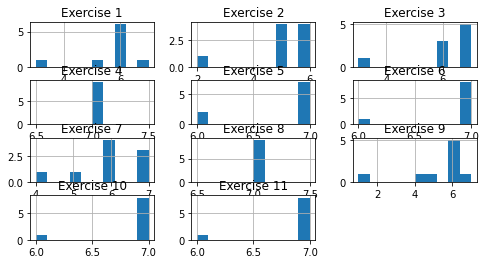

In [47]:
print_stats(data_seq, hist_bins=10)

### Response Frequency

In [48]:
data_seq_freq = (data_seq.apply(pd.value_counts).fillna(0)/data_seq.count()*100).transpose()
data_seq_freq

,1,2,3,4,5,6,7
Exercise 1,0.000000,0.000000,11.111111,0.000000,11.111111,66.666667,11.111111
Exercise 2,0.000000,11.111111,0.000000,0.000000,44.444444,44.444444,0.000000
Exercise 3,0.000000,0.000000,11.111111,0.000000,0.000000,33.333333,55.555556
Exercise 4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000
Exercise 5,0.000000,0.000000,0.000000,0.000000,0.000000,22.222222,77.777778
Exercise 6,0.000000,0.000000,0.000000,0.000000,0.000000,11.111111,88.888889
Exercise 7,0.000000,0.000000,0.000000,11.111111,11.111111,44.444444,33.333333
Exercise 8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000
Exercise 9,11.111111,0.000000,0.000000,11.111111,11.111111,55.555556,11.111111
Exercise 10,0.000000,0.000000,0.000000,0.000000,0.000000,11.111111,88.888889


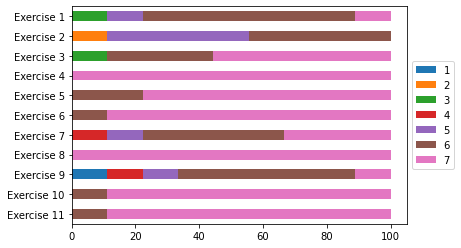

In [49]:
data_seq_freq.iloc[::-1].plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### Overall Pseudo-SEQ Score

In [50]:
data_seq_score = data_seq.mean(axis=1)
data_seq_score

0    6.636364
1    6.818182
2    6.636364
3    6.000000
4    6.454545
5    4.818182
6    6.727273
7    6.545455
8    6.363636
dtype: float64

In [51]:
data_seq_score.describe()

count    9.000000
mean     6.333333
std      0.616575
min      4.818182
25%      6.363636
50%      6.545455
75%      6.636364
max      6.818182
dtype: float64

## Exercises

In [55]:
data_exercises = data['Exercises'].copy()

data_exercises_times = data_exercises.select_dtypes(include='object')
data_exercises_times = data_exercises_times.applymap(convert_time_to_timedelta, na_action='ignore')

data_exercises[data_exercises_times.columns] = data_exercises_times[data_exercises_times.columns]

data_exercises                                                              

,Exercise 1 Total Time,Exercise 1 Time First Needed Help,Exercise 1 Times Needed Help,Exercise 1 Number of Errors,Exercise 2 Total Time,Exercise 2 Time First Needed Help,Exercise 2 Times Needed Help,Exercise 2 Number of Errors,Exercise 3 Total Time,Exercise 3 Time First Needed Help,...,Exercise 9 Times Needed Help,Exercise 9 Number of Errors,Exercise 10 Total Time,Exercise 10 Time First Needed Help,Exercise 10 Times Needed Help,Exercise 10 Number of Errors,Exercise 11 Total Time,Exercise 11 Time First Needed Help,Exercise 11 Times Needed Help,Exercise 11 Number of Errors
0,0 days 00:01:26,NaT,0,0,0 days 00:05:36,0 days 00:02:34,5,1,0 days 00:00:48,0 days 00:00:32,...,2,1,0 days 00:00:39,NaT,0,0,0 days 00:00:11,NaT,0.0,0.0
1,0 days 00:03:21,0 days 00:02:24,1,2,0 days 00:04:15,0 days 00:00:40,3,3,0 days 00:00:30,NaT,...,2,2,0 days 00:00:31,NaT,0,0,0 days 00:00:20,NaT,0.0,0.0
2,0 days 00:02:56,0 days 00:01:33,2,0,0 days 00:04:40,0 days 00:00:13,7,5,0 days 00:01:28,0 days 00:00:17,...,1,0,0 days 00:00:46,0 days 00:00:12,1,1,0 days 00:00:30,0 days 00:00:16,1.0,1.0
3,0 days 00:01:44,NaT,3,0,0 days 00:05:58,0 days 00:00:33,8,3,0 days 00:00:12,0 days 00:00:30,...,3,1,0 days 00:01:04,0 days 00:00:37,1,1,0 days 00:00:25,NaT,0.0,0.0
4,0 days 00:02:13,0 days 00:00:49,3,1,0 days 00:04:44,0 days 00:00:43,5,3,0 days 00:01:32,0 days 00:00:39,...,1,0,0 days 00:00:38,NaT,0,0,0 days 00:00:24,NaT,NaN,NaN
5,0 days 00:04:10,0 days 00:00:51,4,0,0 days 00:04:45,0 days 00:01:14,5,2,0 days 00:01:50,0 days 00:00:33,...,4,2,0 days 00:01:23,0 days 00:00:21,2,1,0 days 00:00:32,0 days 00:00:21,1.0,1.0
6,0 days 00:02:49,0 days 00:01:02,2,1,0 days 00:03:16,0 days 00:00:21,3,2,0 days 00:01:22,0 days 00:00:39,...,4,0,0 days 00:00:31,0 days 00:00:31,1,1,0 days 00:00:25,NaT,0.0,0.0
7,0 days 00:02:10,0 days 00:01:02,1,0,0 days 00:04:03,0 days 00:01:45,5,2,0 days 00:03:10,0 days 00:00:40,...,2,1,0 days 00:00:58,NaT,0,0,0 days 00:00:32,0 days 00:00:32,1.0,0.0
8,0 days 00:01:47,0 days 00:03:37,3,0,0 days 00:04:19,0 days 00:00:14,4,3,0 days 00:02:13,0 days 00:01:37,...,3,0,0 days 00:01:18,0 days 00:00:55,1,1,0 days 00:00:34,NaT,0.0,0.0
